In [12]:
import data
import importlib

# 重新加载data模块
importlib.reload(data)
word_dict = data.load_vocab()

# 加载数据集
train_data, dev_data, test_data = data.load_afqmc_data("/Users/golden/Downloads/深度学习作业/深度学习第四次作业/src/AFQMC数据集")

# 选择一小部分数据进行处理
sample_data = train_data[:10]  # 取训练集的前10条数据进行示例

# 处理数据
processed_sample = [data.words2id(example) for example in sample_data]

# 创建小批量数据并对齐
(input_ids, segment_ids), labels = data.collate_fn(processed_sample)

# 打印验证一条mini-batch的数据
print("Input IDs:", input_ids)
print("Segment IDs:", segment_ids)
print("Labels:", labels)


Input IDs: tensor([[    1,  3802,  2975,  1051,  4947,    43,   852,   201,   699,    48,
            22,   806,    33,   254,   399,    49,    89,  1114,     2,  1051,
          4947,     9,   254,   399,    45,   195,   201,    89,  1114,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  3802,  2975,   283,  4947,   178,    75,  1147,   450,     7,
           218,     2,  3802,  2975,   283,  4947,  1147,   450,    40,    13,
            10,   614,   356,     2,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,   836,    75,   335,     7,    86,   

In [262]:
from torch.utils.data import DataLoader
processed_train = [data.words2id(example) for example in train_data]
processed_dev = [data.words2id(example) for example in dev_data]
processed_test = [data.words2id(example) for example in test_data]

trainloader=DataLoader(processed_train, batch_size=32, collate_fn=data.collate_fn,shuffle=True)
devloader=DataLoader(processed_dev, batch_size=32, collate_fn=data.collate_fn,shuffle=False)
testloader=DataLoader(processed_test, batch_size=32, collate_fn=data.collate_fn,shuffle=False)

# 打印批次数量
print("Number of batches in trainloader:", len(trainloader))
print("Number of batches in devloader:", len(devloader))
print("Number of batches in testloader:", len(testloader))


Number of batches in trainloader: 1073
Number of batches in devloader: 135
Number of batches in testloader: 121


In [286]:
def calculate_label_proportions_from_dataloader(dataloader):
    count_class_0 = 0
    count_class_1 = 0
    total_count = 0

    for _, labels in dataloader:
        count_class_0 += (labels == 0).sum().item()
        count_class_1 += (labels == 1).sum().item()
        total_count += labels.size(0)

    proportion_class_0 = count_class_0 / total_count
    proportion_class_1 = count_class_1 / total_count

    return proportion_class_0, proportion_class_1

# 假设 trainloader 是包含您数据集的 DataLoader
proportion_class_0, proportion_class_1 = calculate_label_proportions_from_dataloader(trainloader)

print(f"Class 0 Proportion: {proportion_class_0}")
print(f"Class 1 Proportion: {proportion_class_1}")


Class 0 Proportion: 0.6920545232131415
Class 1 Proportion: 0.3079454767868585


In [288]:
import torch.nn as nn
import torch
import math
class Embeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len):
        super(Embeddings, self).__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.segment_embeddings = nn.Embedding(2, embedding_dim)
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
    
    def _init_token_embeddings(self):
        # 使用高斯分布初始化词嵌入的权重，标准差为 1 / sqrt(embedding_dim)
        nn.init.normal_(self.token_embeddings.weight, mean=0, std=1 / math.sqrt(self.embedding_dim))
    
    def forward(self, input_ids, segment_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.float32, device=input_ids.device).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2, dtype=torch.float32, device=input_ids.device) * -(math.log(10000.0) / self.embedding_dim))
        div_term = div_term.unsqueeze(0)  # 形状变为(1, embedding_dim // 2)

        # 创建正弦和余弦值
        sin_values = torch.sin(position_ids * div_term)
        cos_values = torch.cos(position_ids * div_term)

    # 交替填充正弦和余弦值
        position_embedding = torch.zeros((seq_length, self.embedding_dim), device=input_ids.device)
        position_embedding[:, 0::2] = sin_values
        position_embedding[:, 1::2] = cos_values[:seq_length, :self.embedding_dim // 2] if self.embedding_dim % 2 == 0 else cos_values[:seq_length, :(self.embedding_dim // 2) + 1]

        # 获取token嵌入和段落嵌入
        token_embeds = self.token_embeddings(input_ids)
        segment_embeds = self.segment_embeddings(segment_ids)

    # 将三个嵌入相加
        embeddings = token_embeds + segment_embeds + position_embedding
        return embeddings



In [301]:
embedding_dim = 768
max_seq_len = 512
vocab_size = len(word_dict)
embedding_layer=Embeddings(vocab_size,embedding_dim,max_seq_len)
InputEmbedding = embedding_layer(input_ids, segment_ids)
#print("Input IDs:\n", input_ids)
#print("\nSegment IDs:\n", segment_ids)
print("\nInputEmbedding  Shape:", InputEmbedding.shape)
print("\nInputEmbedding :\n", InputEmbedding)


InputEmbedding  Shape: torch.Size([32, 51, 768])

InputEmbedding :
 tensor([[[-7.9398e-01,  1.9674e+00,  1.1969e-01,  ...,  4.0921e-01,
          -1.6410e+00,  2.1352e+00],
         [-6.3143e-01,  3.0182e+00,  1.3223e+00,  ..., -8.1392e-01,
          -1.5787e+00,  9.6656e-01],
         [-3.8515e-01,  6.0049e-01,  1.1348e+00,  ...,  3.4055e-01,
          -7.1400e-01,  2.2651e+00],
         ...,
         [-3.0110e+00,  1.8789e+00,  6.1446e-01,  ...,  3.0746e-01,
          -1.9792e+00,  7.8179e-01],
         [-3.1965e+00,  2.8197e+00, -2.9954e-01,  ...,  3.0746e-01,
          -1.9791e+00,  7.8179e-01],
         [-2.5051e+00,  3.4840e+00, -6.3683e-01,  ...,  3.0746e-01,
          -1.9790e+00,  7.8179e-01]],

        [[-7.9398e-01,  1.9674e+00,  1.1969e-01,  ...,  4.0921e-01,
          -1.6410e+00,  2.1352e+00],
         [-6.6358e-01,  1.4178e+00,  9.8791e-01,  ...,  8.8682e-01,
          -1.8639e+00, -5.3761e-02],
         [-8.5917e-01,  3.4996e+00,  3.6076e+00,  ...,  2.5524e-01,
       

In [26]:
def scaled_dot_product_attention(query, key, value):
    """计算缩放点积注意力"""
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 缩放
    depth = query.size(-1)
    scaled_attention_logits = matmul_qk / math.sqrt(depth)

    # softmax应用于最后一个轴
    attention_weights = nn.functional.softmax(scaled_attention_logits, dim=-1)

    output = torch.matmul(attention_weights, value)
    return output, attention_weights


In [106]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim

        # 确保embedding_dim可以被num_heads整除以便均匀分割到每个头
        assert embedding_dim % num_heads == 0

        self.depth = embedding_dim // num_heads

        self.wq = nn.Linear(embedding_dim, embedding_dim)
        self.wk = nn.Linear(embedding_dim, embedding_dim)
        self.wv = nn.Linear(embedding_dim, embedding_dim)

        self.dense = nn.Linear(embedding_dim, embedding_dim)

    def split_into_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, x):
        batch_size = x.size(0)

        q = self.split_into_heads(self.wq(x), batch_size)  # (batch_size, num_heads, seq_length, depth)
        k = self.split_into_heads(self.wk(x), batch_size)
        v = self.split_into_heads(self.wv(x), batch_size)

        # 缩放点积注意力
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)  # (batch_size, seq_length, num_heads, depth)

        concat_attention = scaled_attention.reshape(batch_size, -1, self.embedding_dim)

        output = self.dense(concat_attention)

        return output,attention_weights


In [107]:
class AddNorm(nn.Module):
    def __init__(self, embedding_dim, dropout_rate):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, sublayer_output):
        # sublayer_output是子层（例如多头自注意力层）的输出
        dropout_output = self.dropout(sublayer_output)
        return self.norm(x + dropout_output)  # 残差连接和层归一化


In [114]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.layernorm1 = nn.LayerNorm(embedding_dim)
        self.layernorm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, attention_weights = self.multi_head_attention(x)
        x = self.layernorm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout(ffn_output))
        return x,attention_weights


In [227]:
class SemanticMatchingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, ff_dim, max_seq_len, num_encoder_layers=2, dropout=0):
        super(SemanticMatchingModel, self).__init__()
        self.embeddings = Embeddings(vocab_size, embedding_dim, max_seq_len)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(embedding_dim, num_heads, ff_dim, dropout) for _ in range(num_encoder_layers)])
        self.classifier = nn.Linear(embedding_dim, 2)  # 假设输出是二分类

    def forward(self, input_ids, segment_ids):
        x = self.embeddings(input_ids, segment_ids)
        all_attention_weights = []
        for encoder_layer in self.encoder_layers:
            x, attention_weights = encoder_layer(x)
            all_attention_weights.append(attention_weights)
        logits = self.classifier(x[:, 0])
        # 取编码器输出的第一个元素（对应[CLS]标记）用于分类
        return logits,all_attention_weights


In [110]:
def lr_warmup(current_step, warmup_steps, base_lr, max_lr):
    if current_step < warmup_steps:
        return base_lr + (max_lr - base_lr) * current_step / warmup_steps
    else:
        return max_lr

In [266]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.01)
model = SemanticMatchingModel(vocab_size = len(word_dict),embedding_dim=embedding_dim,
                              num_heads=16,ff_dim=4096,max_seq_len=max_seq_len)
model.apply(weights_init)

SemanticMatchingModel(
  (embeddings): Embeddings(
    (token_embeddings): Embedding(17964, 768)
    (segment_embeddings): Embedding(2, 768)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (multi_head_attention): MultiHeadSelfAttention(
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (dense): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=4096, bias=True)
        (1): ReLU()
        (2): Linear(in_features=4096, out_features=768, bias=True)
      )
      (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (classifier): Linear(in_features=768, out_features=2, bias

In [302]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import LambdaLR

# 初始化模型、损失函数、优化器
model = SemanticMatchingModel(vocab_size = len(word_dict),embedding_dim=embedding_dim,
                              num_heads=16,ff_dim=4096,max_seq_len=max_seq_len)

model.apply(weights_init)

print(model)
weight_for_class_0 = 1 / proportion_class_0
weight_for_class_1 = 1 / proportion_class_1
class_weights = torch.tensor([weight_for_class_0, weight_for_class_1]) 

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
warmup_steps = 250
num_epochs=10
total_steps = num_epochs * len(trainloader)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_warmup(step, warmup_steps, 1e-6, 1e-4))

# 初始化TensorBoard
writer = SummaryWriter('logs/semantic_matching')
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc='Training')
    for i, batch in progress_bar:
        (input_ids, segment_ids), labels = batch
        optimizer.zero_grad()
        outputs,all_attention_weights = model(input_ids, segment_ids)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        #scheduler.step()
        
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix(loss=np.mean(train_losses), accuracy=100. * train_correct / train_total)

    # 验证循环
    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    progress_bar = tqdm(enumerate(devloader), total=len(devloader), desc='Validation')
    with torch.no_grad():
        for i, batch in progress_bar:
            (input_ids, segment_ids), labels = batch
            outputs,all_attention_weights = model(input_ids, segment_ids)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=np.mean(val_losses), accuracy=100. * val_correct / val_total)

        accuracy = 100. * val_correct / val_total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    # 记录到TensorBoard
    writer.add_scalar('Training Loss', np.mean(train_losses), epoch)
    writer.add_scalar('Training Accuracy', 100. * train_correct / train_total, epoch)
    writer.add_scalar('Validation Loss', np.mean(val_losses), epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)
    writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch * len(trainloader) + i)

SemanticMatchingModel(
  (embeddings): Embeddings(
    (token_embeddings): Embedding(17964, 768)
    (segment_embeddings): Embedding(2, 768)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (multi_head_attention): MultiHeadSelfAttention(
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (dense): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=4096, bias=True)
        (1): ReLU()
        (2): Linear(in_features=4096, out_features=768, bias=True)
      )
      (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (classifier): Linear(in_features=768, out_features=2, bias

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [239]:
import shutil
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

# 删除旧的TensorBoard日志目录（谨慎操作，以免丢失数据）
log_dir = 'logs/semantic_matching'
try:
    shutil.rmtree(log_dir)
except OSError as e:
    print(f"Error: {log_dir} : {e.strerror}")

# 创建新的TensorBoard写入器
writer = SummaryWriter(log_dir)

# 创建新的模型实例
model = SemanticMatchingModel(vocab_size = len(word_dict),embedding_dim=embedding_dim,
                              num_heads=8,ff_dim=2048,max_seq_len=max_seq_len)
criterion = nn.CrossEntropyLoss()

# 创建新的优化器
optimizer = Adam(model.parameters(), lr=1e-4)



In [278]:
import random

# 加载保存的模型
model = SemanticMatchingModel(vocab_size = len(word_dict),embedding_dim=embedding_dim,
                              num_heads=16,ff_dim=4096,max_seq_len=max_seq_len)  # 用与训练时相同的参数初始化模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # 将模型设置为评估模式

# 从测试集中随机选择50条数据
random_samples = random.sample(processed_dev, 50)

# 创建一个DataLoader来加载这些样本
sample_loader = DataLoader(random_samples, batch_size=len(random_samples), collate_fn=data.collate_fn)
correct = 0
total = 0

with torch.no_grad():
    for batch in sample_loader:
        (input_ids, segment_ids), labels = batch
        outputs,all_attention_weights = model(input_ids, segment_ids)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the 50 random test samples: {accuracy}%')


Accuracy on the 50 random test samples: 68.0%


torch.Size([84, 84])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 20511 (\N{CJK UNIFIED IDEOGRAPH-501F}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 21591 (\N{CJK UNIFIED IDEOGRAPH-5457}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 36824 (\N{CJK UNIFIED IDEOGRAPH-8FD8}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 28165 (\N{CJK UNIFIED IDEOGRAPH-6E05}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.

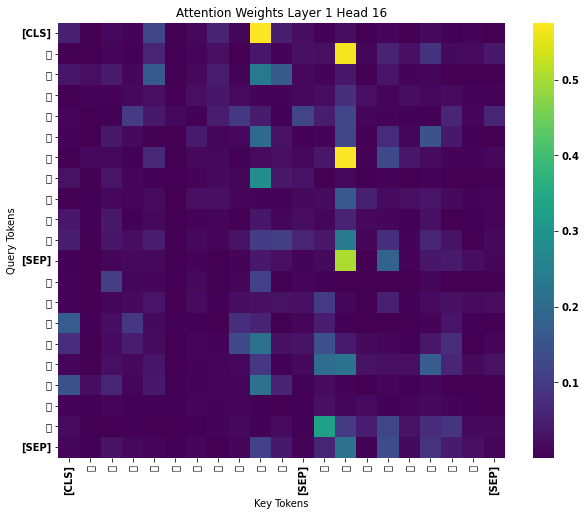

['[CLS]', '借', '呗', '还', '清', '后', '多', '久', '还', '能', '用', '[SEP]', '频', '繁', '使', '用', '借', '呗', '还', '款', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [279]:
sample_id = 30 # 选择样本的索引
sample_input_ids = input_ids[sample_id].unsqueeze(0)
sample_segment_ids = segment_ids[sample_id].unsqueeze(0)  # 如果模型使用了segment_ids

index_to_word = {idx: word for word, idx in word_dict.items()}
input_tokens = [index_to_word.get(index.item(), '[UNK]') for index in sample_input_ids[0]]

import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # 将模型设置为评估模式

with torch.no_grad():
    # 通过模型传递数据
    output, all_attention_weights = model(sample_input_ids, sample_segment_ids)
# 假设您想查看第一层第一个头的注意力权重的形状
layer = 0
head = 15


attention_weights_layer= all_attention_weights[layer].squeeze(0)  # 移除批次维度，如果有的话
attention_weights_head=attention_weights_layer[head].squeeze(0)
print(attention_weights_head.shape)
# 将权重转换为numpy数组以便可视化
attention_weights_numpy = attention_weights_head.detach().numpy()

pad_token_id = word_dict['[PAD]']

# 找到第一个填充项的索引
pad_index = (sample_input_ids[0] == pad_token_id).nonzero(as_tuple=True)[0]
if len(pad_index) > 0:
    pad_index = pad_index[0].item()  # 第一个填充项的索引
else:
    pad_index = sample_input_ids[0].size(0)  # 没有填充项，使用整个长度

# 切片以排除填充项
attention_weights_sliced = attention_weights_numpy[:pad_index, :pad_index]
input_tokens_sliced = input_tokens[:pad_index]

# 创建热力图
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights_sliced, xticklabels=input_tokens_sliced, yticklabels=input_tokens_sliced, cmap='viridis', annot=False)

# 设置标题和坐标轴标签
plt.title(f'Attention Weights Layer {layer+1} Head {head+1}')
plt.xlabel('Key Tokens')
plt.ylabel('Query Tokens')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print(input_tokens)


In [216]:
class SemanticMatchingModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, ff_dim, max_seq_len, num_encoder_layers=3, dropout=0.1):
        super(SemanticMatchingModel2, self).__init__()
        self.embeddings = Embeddings(vocab_size, embedding_dim, max_seq_len)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(embedding_dim, num_heads, ff_dim, dropout) for _ in range(num_encoder_layers)])
        self.classifier = nn.Linear(embedding_dim, 2)  # 假设输出是二分类

    def forward(self, input_ids, segment_ids):
        x = self.embeddings(input_ids, segment_ids)
        all_attention_weights = []
        for encoder_layer in self.encoder_layers:
            x, attention_weights = encoder_layer(x)
            all_attention_weights.append(attention_weights)
        logits = self.classifier(x[:, 0])
        # 取编码器输出的第一个元素（对应[CLS]标记）用于分类
        return logits,all_attention_weights


In [282]:
deepermodel = SemanticMatchingModel2(vocab_size = len(word_dict),embedding_dim=embedding_dim,
                              num_heads=16,ff_dim=4096,max_seq_len=max_seq_len)

print(deepermodel)
deepermodel.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deepermodel.parameters(), lr=1e-4)
warmup_steps = 500
num_epochs=5
total_steps = num_epochs * len(trainloader)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_warmup(step, warmup_steps, 1e-6, 1e-4))

# 初始化TensorBoard
writer = SummaryWriter('logs/semantic_matching_deeper')
best_accuracy = 0
for epoch in range(num_epochs):
    deepermodel.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc='Training')
    for i, batch in progress_bar:
        (input_ids, segment_ids), labels = batch
        optimizer.zero_grad()
        outputs,all_attention_weights = deepermodel(input_ids, segment_ids)
        loss = criterion(outputs, labels)
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix(loss=np.mean(train_losses), accuracy=100. * train_correct / train_total)

    # 验证循环
    deepermodel.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    progress_bar = tqdm(enumerate(devloader), total=len(devloader), desc='Validation')
    with torch.no_grad():
        for i, batch in progress_bar:
            (input_ids, segment_ids), labels = batch
            outputs,all_attention_weights = deepermodel(input_ids, segment_ids)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=np.mean(val_losses), accuracy=100. * val_correct / val_total)

        accuracy = 100. * val_correct / val_total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model_deeper.pth')

    # 记录到TensorBoard
    writer.add_scalar('Training Loss', np.mean(train_losses), epoch)
    writer.add_scalar('Training Accuracy', 100. * train_correct / train_total, epoch)
    writer.add_scalar('Validation Loss', np.mean(val_losses), epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)
    writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch * len(trainloader) + i)

SemanticMatchingModel2(
  (embeddings): Embeddings(
    (token_embeddings): Embedding(17964, 768)
    (segment_embeddings): Embedding(2, 768)
  )
  (encoder_layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (multi_head_attention): MultiHeadSelfAttention(
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (dense): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=4096, bias=True)
        (1): ReLU()
        (2): Linear(in_features=4096, out_features=768, bias=True)
      )
      (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=768, out_features=2, b

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/1073 [00:00<?, ?it/s]

Validation:   0%|          | 0/135 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import LambdaLR

model.apply(weights_init)

print(model)
weight_for_class_0 = 1 / proportion_class_0
weight_for_class_1 = 1 / proportion_class_1
class_weights = torch.tensor([weight_for_class_0, weight_for_class_1]) 

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
warmup_steps = 250
num_epochs=10
total_steps = num_epochs * len(trainloader)
#scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_warmup(step, warmup_steps, 1e-6, 1e-4))

# 初始化TensorBoard
writer = SummaryWriter('logs/bertsemantic_matching')
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc='Training')
    for i, batch in progress_bar:
        (input_ids, segment_ids), labels = batch
        optimizer.zero_grad()
        outputs,all_attention_weights = model(input_ids, segment_ids)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        #scheduler.step()
        
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix(loss=np.mean(train_losses), accuracy=100. * train_correct / train_total)

    # 验证循环
    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    progress_bar = tqdm(enumerate(devloader), total=len(devloader), desc='Validation')
    with torch.no_grad():
        for i, batch in progress_bar:
            (input_ids, segment_ids), labels = batch
            outputs,all_attention_weights = model(input_ids, segment_ids)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=np.mean(val_losses), accuracy=100. * val_correct / val_total)

        accuracy = 100. * val_correct / val_total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    # 记录到TensorBoard
    writer.add_scalar('Training Loss', np.mean(train_losses), epoch)
    writer.add_scalar('Training Accuracy', 100. * train_correct / train_total, epoch)
    writer.add_scalar('Validation Loss', np.mean(val_losses), epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)
    #writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch * len(trainloader) + i)